In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import  mean_squared_error, mean_absolute_error, root_mean_squared_error

In [2]:
#random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
data = pd.read_csv('../data/processed_trips_2018.csv')
stations = pd.read_csv('../data/processed_stations_2018.csv')
weather = pd.read_csv('../data/weather_2018.csv')

We assign the station clusters to the start station ids because this is where the bikes are going to be picked up from 

In [4]:
data["station_cluster"] = data["start_station_id"].map(stations.set_index("station_id")["station_cluster"])

In [5]:
weather_cols = ["datetime","temp","feelslike","dew","humidity","precip","precipprob","snow","snowdepth","windgust","windspeed","sealevelpressure","visibility"]

In [6]:
weather_cleaned = weather[weather_cols]
weather_cleaned['datetime'] = pd.to_datetime(weather_cleaned['datetime'])

#backfill missing weather data
weather_cleaned = weather_cleaned.sort_values('datetime').set_index('datetime').asfreq('h')
weather_cleaned = weather_cleaned.fillna(method='ffill')
weather_cleaned = weather_cleaned.reset_index()

weather_cleaned["day_of_week"] = weather_cleaned["datetime"].dt.dayofweek
weather_cleaned["hour_of_day"] = weather_cleaned["datetime"].dt.hour

/var/folders/c6/k78nzngn7nbdd0786bxl3s0c0000gn/T/ipykernel_46030/2738095026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_cleaned['datetime'] = pd.to_datetime(weather_cleaned['datetime'])
/var/folders/c6/k78nzngn7nbdd0786bxl3s0c0000gn/T/ipykernel_46030/2738095026.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_cleaned = weather_cleaned.fillna(method='ffill')


### Check how many bikes on average per hour per cluster

When deciding which clusters to focus on , at least as a starting point, we consider the amount of bikes that are picked up in thast cluster per hour

In [7]:
bikes_per_day = data.groupby(['station_cluster', 'pickup_datetime']).size().reset_index(name='num_rentals')
avg_bikes_per_cluster = bikes_per_day.groupby('station_cluster')['num_rentals'].mean().sort_values(ascending=False).reset_index(name='avg_num_rentals')

In [8]:
cluster = data[data['station_cluster'] == avg_bikes_per_cluster.iloc[0]['station_cluster']]

In [9]:
hourly_pickups_cluster = cluster.groupby(['pickup_datetime'])['bikeid'].size().reset_index(name='num_rentals')
hourly_dropoffs_cluster = cluster.groupby(['dropoff_datetime'])['bikeid'].size().reset_index(name='num_rentals')

In [10]:
hourly_cluster = pd.merge(hourly_pickups_cluster, hourly_dropoffs_cluster, left_on='pickup_datetime', right_on='dropoff_datetime', how='outer', suffixes=('_pickups', '_dropoffs')).drop(columns=['dropoff_datetime']).rename(columns={'pickup_datetime': 'datetime'})
hourly_cluster['datetime'] = pd.to_datetime(hourly_cluster['datetime'])

In [11]:
hourly_cluster = hourly_cluster[hourly_cluster['datetime'] < '2019-01-01']
hourly_cluster

,datetime,num_rentals_pickups,num_rentals_dropoffs
0,2018-01-01 00:00:00,18.0,14.0
1,2018-01-01 01:00:00,30.0,29.0
2,2018-01-01 02:00:00,11.0,16.0
3,2018-01-01 03:00:00,9.0,6.0
4,2018-01-01 04:00:00,2.0,5.0
...,...,...,...
8723,2018-12-31 19:00:00,20.0,21.0
8724,2018-12-31 20:00:00,28.0,30.0
8725,2018-12-31 21:00:00,7.0,8.0
8726,2018-12-31 22:00:00,9.0,11.0


In [12]:
print(f'size of hourly_cluster: {hourly_cluster.shape}')
def fill_missing_hours(df):
    all_hours = pd.date_range(start=df['datetime'].min(), end=df['datetime'].max(), freq='h')
    all_hours_df = pd.DataFrame({'datetime': all_hours})
    all_hours_df["datetime"] = pd.to_datetime(all_hours_df["datetime"])
    merged_df = pd.merge(all_hours_df, df, on=['datetime'], how='left')
    merged_df['num_rentals_pickups'] = merged_df['num_rentals_pickups'].fillna(0).astype(int)
    merged_df['num_rentals_dropoffs'] = merged_df['num_rentals_dropoffs'].fillna(0).astype(int)

    return merged_df

hourly_cluster = fill_missing_hours(hourly_cluster)
print(f'size of hourly_cluster after filling missing hours: {hourly_cluster.shape}')

size of hourly_cluster: (8721, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


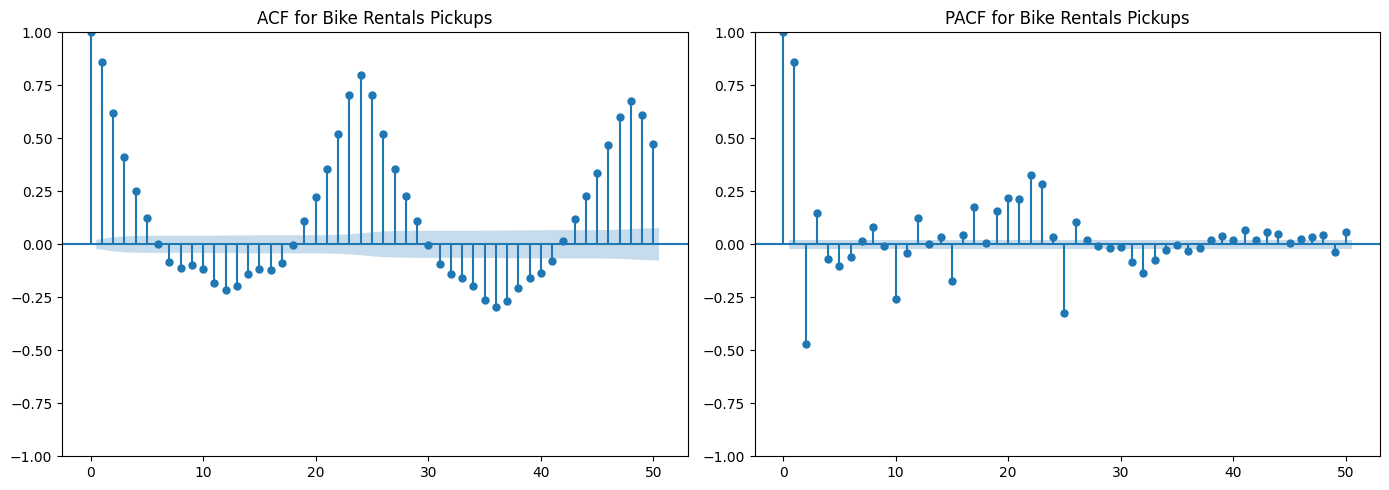

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=50, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    
    plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title(f'ACF {title_suffix}')
    
    plot_pacf(series, lags=lags, ax=axes[1], method='ywm') 
    axes[1].set_title(f'PACF {title_suffix}')
    
    plt.tight_layout()
    plt.show()
plot_acf_pacf(hourly_cluster['num_rentals_pickups'], lags=50, title_suffix='for Bike Rentals Pickups')

ACF: decays slowly, crosses significance after lag 5, then rises at multiples of 24 hours.

PACF: significant at lag 0 and 1 positive, lag 2 negative, then essentially small values.

Slow decay in ACF → indicates strong autocorrelation / possible AR component.

PACF spikes at lag 1 → suggests AR(1) term is relevant.

ACF peaks at multiples of 24 hours → indicates daily seasonality (hourly data).

Beyond lag 5, ACF is mostly noise → MA terms may be limited to small lags.

## Train Time Series

In [14]:
##CONSTANTS
END_TRAINING_DATE = pd.to_datetime("2018-09-01 00:00:00")
END_VALIDATION_DATE = pd.to_datetime("2018-11-01 00:00:00")

## Split train - Test

In [15]:
train_data = hourly_cluster[hourly_cluster['datetime'] < END_VALIDATION_DATE].set_index('datetime')
test_data = hourly_cluster[hourly_cluster['datetime'] >= END_VALIDATION_DATE].set_index('datetime')

train_data.index = pd.to_datetime(train_data.index)
test_data.index  = pd.to_datetime(test_data.index)

train_weather  = weather_cleaned[weather_cleaned['datetime'] < END_VALIDATION_DATE].set_index('datetime')
test_weather   = weather_cleaned[weather_cleaned['datetime'] >= END_VALIDATION_DATE].set_index('datetime')

In [16]:
train_data = train_data.asfreq('h')
test_data = test_data.asfreq('h')

In [17]:
train_exog = train_weather[['temp','feelslike','dew','humidity','precip','precipprob','snow','snowdepth','windspeed','sealevelpressure','visibility']]
train_exog.index = train_data.index

test_exog = test_weather[['temp','feelslike','dew','humidity','precip','precipprob','snow','snowdepth','windspeed','sealevelpressure','visibility']]
test_exog.index = test_data.index

train_exog_short = train_exog[['feelslike','precip','visibility']]

test_exog_short = test_exog[['feelslike','precip','visibility']]

In [18]:
def print_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = round(mean_absolute_error(y_true, y_pred), 2)
    rmse = round(np.sqrt(mse), 2)
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    return mae, rmse

def plot_predictions_vs_true(test_data, predicted_column, true_column):
        plt.figure(figsize=(15, 6))
        plt.plot(test_data.index, test_data[true_column], label='Actual', color='blue')
        plt.plot(test_data.index, test_data[predicted_column], label='Predicted', color='orange')
        plt.xlabel('Datetime')
        plt.ylabel('Number of Rentals')
        plt.title('ARIMA Model: Actual vs Predicted Number of Rentals')
        plt.legend()
        plt.show()
    

In [19]:
PICKUP_TARGET_COL = 'num_rentals_pickups'
DROPOFF_TARGET_COL = 'num_rentals_dropoffs'

In [20]:
performance_pickup = {}
performance_dropoffs= {}

# PREDICTION OF PICK UPS

In [21]:
folds_config = [
    {'train_start': pd.Timestamp('2018-01-01 00:00:00'), 
     'train_end': pd.Timestamp('2018-06-30 23:00:00'),
     'val_start': pd.Timestamp('2018-07-01 00:00:00'), 
     'val_end': pd.Timestamp('2018-08-31 23:00:00')},
    {'train_start': pd.Timestamp('2018-01-01 00:00:00'), 
     'train_end': pd.Timestamp('2018-08-31 23:00:00'),
     'val_start': pd.Timestamp('2018-09-01 00:00:00'), 
     'val_end': pd.Timestamp('2018-10-31 23:00:00')}
]

### After looking at ACF and PACF we try a SARIMA model

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarimax_fit_predict_folds_daily(folds_config, train_data, target, order, s_order, exog=None):
    
    maes = []
    rmses= []
    for i, fold in enumerate(folds_config, 1):
        trues= []
        preds = []
        train_fold = train_data.loc[fold['train_start']:fold['train_end']]
        val_fold   = train_data.loc[fold['val_start']:fold['val_end']].copy()

        val_fold_midnight = val_fold[val_fold.index.hour == 0]

        if exog is not None:
            exog_train = exog.loc[fold['train_start']:fold['train_end']]
            exog_val   = exog.loc[val_fold_midnight.index[0]:val_fold_midnight.index[-1]+pd.Timedelta(hours=23)]
        else:
            exog_train = None
            exog_val = None

        # Fit SARIMAX
        model = SARIMAX(
            train_fold[target],
            exog=exog_train,
            order=order,
            seasonal_order=s_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)
        print(f"Fold {i} SARIMAX summary:")
        print(model_fit.summary())

        for start_time in val_fold_midnight.index:
            end_time = start_time + pd.Timedelta(hours=23)
            if exog_val is not None:
                exog_slice = exog_val.loc[start_time:end_time]
            else:
                exog_slice = None

            pred = model_fit.forecast(steps=24, exog=exog_slice)
            pred = np.clip(pred.values, 0, None)

            true = val_fold.loc[start_time:end_time, target]

            trues.append(true)
            preds.append(pd.Series(pred, index=true.index))
            
        trues = pd.concat(trues)
        preds = pd.concat(preds)
        mae_fold, rmse_fold = print_metrics(trues, preds)
        maes.append(mae_fold)
        rmses.append(rmse_fold)

    avg_mae = np.round(np.mean(maes),2)
    avg_rmse = np.round(np.mean(rmses),2)
    return avg_mae, avg_rmse


def sarimax_fit_predict(train_data, test_data, target, order, s_order, new_col, exog_train=None, exog_test=None):
    model = SARIMAX(
        train_data[target],
        exog=exog_train,
        order=order,             
        seasonal_order=s_order, 
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)
    print(model_fit.summary())

    trues = []
    preds = []

    test_midnight = test_data[test_data.index.hour == 0]

    for start_time in test_midnight.index:
        end_time = start_time + pd.Timedelta(hours=23)
        if exog_test is not None:
            exog_slice = exog_test.loc[start_time:end_time]
        else:
            exog_slice = None

        # Forecast next 24 hours
        pred = model_fit.forecast(steps=24, exog=exog_slice)
        pred = np.clip(pred.values, 0, None)

        # True values
        true = test_data.loc[start_time:end_time, target]

        trues.append(true)
        preds.append(pd.Series(pred, index=true.index))

    # Concatenate all days
    trues = pd.concat(trues)
    preds = pd.concat(preds)

    # Compute metrics
    mae, rmse = print_metrics(trues, preds)

    # Plot predictions vs true values
    df_plot = pd.DataFrame({
        'Actual': trues,
        'Predicted': preds
    })
    plot_predictions_vs_true(df_plot, 'Predicted', 'Actual')

    return mae, rmse


In [23]:
s_order = (1,0,1,24) #24 hours per day
order=(1,0,4)
print(f'Prediciting {PICKUP_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, PICKUP_TARGET_COL, order,s_order)
performance_pickup["model_sarima"] = {"val_mae": mae, "val_rmse": rmse}

print(f'Prediciting {DROPOFF_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, DROPOFF_TARGET_COL, order,s_order)
performance_dropoffs["model_sarima"] = {"val_mae": mae, "val_rmse": rmse}

Prediciting num_rentals_pickups


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -23859.031
Date:                              Sat, 29 Nov 2025   AIC                          47734.063
Time:                                      18:30:16   BIC                          47785.021
Sample:                                  01-01-2018   HQIC                         47752.057
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9667      0.018    -53.641      0.000      -1.002      -0

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -32533.986
Date:                              Sat, 29 Nov 2025   AIC                          65083.973
Time:                                      18:30:37   BIC                          65137.302
Sample:                                  01-01-2018   HQIC                         65102.523
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9186      0.039    -23.758      0.000      -0.994      -0

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -23773.627
Date:                              Sat, 29 Nov 2025   AIC                          47563.255
Time:                                      18:30:54   BIC                          47614.214
Sample:                                  01-01-2018   HQIC                         47581.249
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5544      0.100     -5.520      0.000      -0.751      -0

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -32528.810
Date:                              Sat, 29 Nov 2025   AIC                          65073.621
Time:                                      18:31:14   BIC                          65126.950
Sample:                                  01-01-2018   HQIC                         65092.171
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4778      0.164      2.915      0.004       0.157       0

### 3. We add exogenous variables

In [24]:
print(f'Prediciting {PICKUP_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, PICKUP_TARGET_COL, order,s_order, train_exog)
performance_pickup["model_sarimax"] = {"val_mae": mae, "val_rmse": rmse}

print(f'Prediciting {DROPOFF_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, DROPOFF_TARGET_COL, order,s_order, train_exog)
performance_dropoffs["model_sarimax"] = {"val_mae": mae, "val_rmse": rmse}

Prediciting num_rentals_pickups


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -24086.047
Date:                              Sat, 29 Nov 2025   AIC                          48210.093
Time:                                      18:32:15   BIC                          48331.120
Sample:                                  01-01-2018   HQIC                         48252.829
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temp                -9.5225      5.674     -1.678      0.093  

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -32868.266
Date:                              Sat, 29 Nov 2025   AIC                          65774.532
Time:                                      18:33:32   BIC                          65901.189
Sample:                                  01-01-2018   HQIC                         65818.590
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temp                -4.7586      5.699     -0.835      0.404  

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -23852.548
Date:                              Sat, 29 Nov 2025   AIC                          47743.096
Time:                                      18:34:25   BIC                          47864.123
Sample:                                  01-01-2018   HQIC                         47785.832
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temp               -10.3920      5.324     -1.952      0.051  

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -32550.596
Date:                              Sat, 29 Nov 2025   AIC                          65139.192
Time:                                      18:35:44   BIC                          65265.849
Sample:                                  01-01-2018   HQIC                         65183.250
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temp                -6.4226      5.300     -1.212      0.226  

### 3. We keep only the relevant exogenous variables

In [25]:
print(f'Prediciting {PICKUP_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, PICKUP_TARGET_COL, order,s_order, train_exog_short)
performance_pickup["model_sarimax_short"] = {"val_mae": mae, "val_rmse": rmse}

print(f'Prediciting {DROPOFF_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, DROPOFF_TARGET_COL, order,s_order, train_exog_short)
performance_dropoffs["model_sarimax_short"] = {"val_mae": mae, "val_rmse": rmse}

Prediciting num_rentals_pickups


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -23760.294
Date:                              Sat, 29 Nov 2025   AIC                          47542.588
Time:                                      18:36:23   BIC                          47612.656
Sample:                                  01-01-2018   HQIC                         47567.330
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feelslike      3.8371      0.553      6.934      0.000       2.752       4

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -32486.105
Date:                              Sat, 29 Nov 2025   AIC                          64994.210
Time:                                      18:37:16   BIC                          65067.537
Sample:                                  01-01-2018   HQIC                         65019.717
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feelslike      3.8356      0.700      5.477      0.000       2.463       5

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -23487.732
Date:                              Sat, 29 Nov 2025   AIC                          46997.464
Time:                                      18:37:56   BIC                          47067.532
Sample:                                  01-01-2018   HQIC                         47022.206
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feelslike      3.8436      0.546      7.039      0.000       2.773       4

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -32212.369
Date:                              Sat, 29 Nov 2025   AIC                          64446.737
Time:                                      18:38:47   BIC                          64520.064
Sample:                                  01-01-2018   HQIC                         64472.244
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feelslike      4.3450      0.620      7.005      0.000       3.129       5

## 4. Adding day and hour

In [26]:
train_exog_w_date = train_weather[['feelslike','precip','visibility', 'day_of_week', 'hour_of_day']]
train_exog_w_date = pd.get_dummies(train_exog_w_date, columns=['hour_of_day', 'day_of_week'], drop_first=True).astype(float)
train_exog_w_date.index = train_data.index

test_exog_w_date = test_weather[['feelslike','precip','visibility', 'day_of_week', 'hour_of_day']]
test_exog_w_date = pd.get_dummies(test_exog_w_date, columns=['hour_of_day', 'day_of_week'], drop_first=True).astype(float)
test_exog_w_date.index = test_data.index

print(f'Prediciting {PICKUP_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, PICKUP_TARGET_COL, order,s_order, train_exog_w_date)
performance_pickup["model_sarimax_short_w_date"] = {"val_mae": mae, "val_rmse": rmse}

print(f'Prediciting {DROPOFF_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, DROPOFF_TARGET_COL, order,s_order, train_exog_w_date)
performance_dropoffs["model_sarimax_short_w_date"] = {"val_mae": mae, "val_rmse": rmse}

Prediciting num_rentals_pickups
Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -23405.172
Date:                              Sat, 29 Nov 2025   AIC                          46890.343
Time:                                      18:41:15   BIC                          47145.137
Sample:                                  01-01-2018   HQIC                         46980.314
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
feelslike          5.2269      0.2

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -31872.806
Date:                              Sat, 29 Nov 2025   AIC                          63825.611
Time:                                      18:44:15   BIC                          64092.256
Sample:                                  01-01-2018   HQIC                         63918.365
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
feelslike          2.3679      0.441      5.372      0.000       1

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -23220.761
Date:                              Sat, 29 Nov 2025   AIC                          46521.521
Time:                                      18:46:04   BIC                          46776.316
Sample:                                  01-01-2018   HQIC                         46611.492
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
feelslike          6.2203      0.274     22.701      0.000       5

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -31545.040
Date:                              Sat, 29 Nov 2025   AIC                          63170.080
Time:                                      18:48:12   BIC                          63436.725
Sample:                                  01-01-2018   HQIC                         63262.833
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
feelslike          4.6358      0.262     17.684      0.000       4

# NN

In [27]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [28]:
def get_dataset(hourly_cluster,n_lags, forecast_horizon, target):
    train_data_nn = hourly_cluster.set_index('datetime')
    # --- Create lag features ---
    df = train_data_nn[[target]].copy()
    lags= {f'target_lag_{lag}': df[target].shift(lag) for lag in range(1, n_lags+1)}
    lags_df = pd.DataFrame(lags, index=df.index)
    df = pd.concat([df, lags_df], axis=1)

    exog_features = ['day_of_week','hour_of_day','feelslike', 'precip', 'visibility']
    df[exog_features] = weather_cleaned.set_index('datetime')[exog_features].loc[df.index]

    # --- Create multi-step target ---
    for step in range(1, forecast_horizon + 1):
        df[f'target_+{step}'] = df[target].shift(-step)

    # --- Drop rows with NaNs due to lags or forward targets ---
    all_columns = [f'target_lag_{lag}' for lag in range(1, n_lags + 1)] + exog_features + \
              [f'target_+{step}' for step in range(1, forecast_horizon + 1)]

    df = df.dropna(subset=all_columns)
    # --- Keep only rows at midnight (00:00) for end-of-day prediction ---
    df = df[df.index.hour == 0]

    return df

# --- Parameters ---
n_lags = 168        # previous week of hourly data
forecast_horizon = 24  # next 24 hours

df_pickup = get_dataset(hourly_cluster, n_lags, forecast_horizon, PICKUP_TARGET_COL)
df_dropoff =get_dataset(hourly_cluster, n_lags, forecast_horizon, DROPOFF_TARGET_COL)

In [29]:
def split_datesets(df, END_TRAINING_DATE, END_VALIDATION_DATE, target, exog_features, forecast_horizon):

    X = df[[f'target_lag_{lag}' for lag in range(1, n_lags+1)] + exog_features].values
    y = df[[f'target_+{step}' for step in range(1, forecast_horizon+1)]].values

    X_train = X[df.index < END_TRAINING_DATE]
    y_train = y[df.index < END_TRAINING_DATE]

    X_val = X[(df.index >= END_TRAINING_DATE) & (df.index < END_VALIDATION_DATE)]
    y_val = y[(df.index >= END_TRAINING_DATE) & (df.index < END_VALIDATION_DATE)]

    X_train_final = X[df.index < END_VALIDATION_DATE]
    y_train_final = y[df.index < END_VALIDATION_DATE]

    X_test = X[df.index >= END_VALIDATION_DATE]
    y_test = y[df.index >= END_VALIDATION_DATE]

    return X_train, y_train, X_val, y_val, X_train_final, y_train_final, X_test, y_test

exog_features = ['day_of_week','hour_of_day','feelslike', 'precip', 'visibility']

X_p_train, y_p_train, X_p_val, y_p_val, X_p_train_final, y_p_train_final, X_p_test, y_p_test = split_datesets(df_pickup, END_TRAINING_DATE, END_VALIDATION_DATE,PICKUP_TARGET_COL,exog_features,forecast_horizon)

X_d_train, y_d_train, X_d_val, y_d_val, X_d_train_final, y_d_train_final, X_d_test, y_d_test = split_datesets(df_dropoff, END_TRAINING_DATE, END_VALIDATION_DATE,DROPOFF_TARGET_COL,exog_features,forecast_horizon)

In [30]:
from sklearn.preprocessing import StandardScaler

# Pickups
scaler_pickup = StandardScaler()
X_pickup_train_scaled = scaler_pickup.fit_transform(X_p_train)
X_pickup_val_scaled = scaler_pickup.transform(X_p_val)

# Dropoffs
scaler_dropoff = StandardScaler()
X_dropoff_train_scaled = scaler_dropoff.fit_transform(X_d_train)
X_dropoff_val_scaled = scaler_dropoff.transform(X_d_val)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

def create_nn_and_train(X_train_scaled, y_train):

    model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(forecast_horizon) 
        ])
    
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )
    return model

def predict_nn(model, X_val_scaled, y_val):
    y_pred = model.predict(X_val_scaled)
    y_pred = np.clip(y_pred, 0, None)

    # Flatten for all predictions
    y_val_flat = y_val.flatten()
    y_pred_flat = y_pred.flatten()

    # Metrics
    mae, rmse = print_metrics(y_val_flat, y_pred_flat)
    return y_val_flat, y_pred_flat, mae, rmse


In [ ]:
p_train_model = create_nn_and_train(X_pickup_train_scaled, y_p_train)
y_val_flat, y_pred_flat, mae_p_train, rmse_p_train = predict_nn(p_train_model, X_pickup_val_scaled, y_p_val)

Epoch 1/50


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 77498.0234 - val_loss: 123883.5625
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 77188.2578 - val_loss: 123456.3984
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 76743.9062 - val_loss: 122820.1250
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 76093.4609 - val_loss: 121782.0000
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 75040.8047 - val_loss: 120111.9141
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 73402.6250 - val_loss: 117459.5391
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 70952.1250 - val_loss: 113296.5391
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 67634.9141 - val_loss: 107190.6250
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 62895.6328 - val_loss: 98832.6797
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 57473.4805 - val_loss: 88102.8203
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 51830.0586 - val_loss: 75079.2266
Epoch 12/5

In [33]:
val_start = pd.Timestamp('2018-09-01 00:00:00')
val_end   = pd.Timestamp('2018-10-31 23:00:00')  

hourly_index = pd.date_range(start=val_start, end=val_end, freq='H')

df_hourly_val = pd.DataFrame(index=hourly_index)
df_hourly_val["y_pred"] = y_pred_flat
df_hourly_val["y_true"] = y_val_flat

/var/folders/c6/k78nzngn7nbdd0786bxl3s0c0000gn/T/ipykernel_46030/2041489759.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=val_start, end=val_end, freq='H')


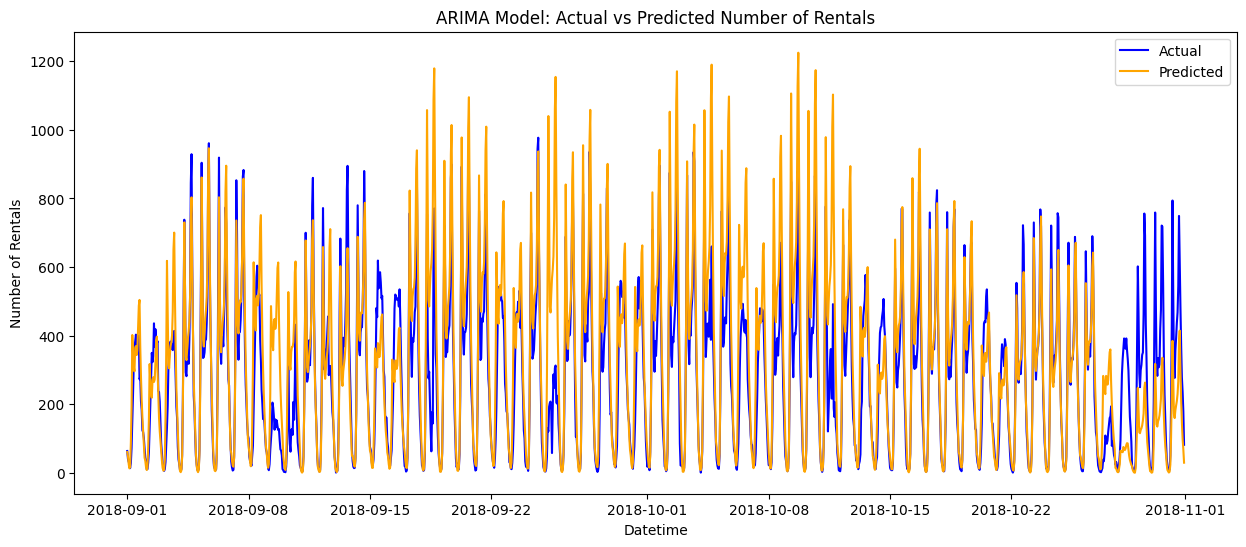

In [34]:
plot_predictions_vs_true(df_hourly_val, "y_pred", "y_true")

In [35]:
d_train_model = create_nn_and_train(X_dropoff_train_scaled, y_d_train)
y_val_flat_d, y_pred_flat_d, mae_d_train, rmse_d_train = predict_nn(d_train_model, X_dropoff_val_scaled, y_d_val)
performance_dropoffs["model_nn"] = {"val_mae": np.round(np.mean(mae_d_train),2), "val_rmse": np.round(np.mean(rmse_d_train),2)}

Epoch 1/50


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 76912.6562 - val_loss: 122767.6641
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 76585.2031 - val_loss: 122218.3359
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 76097.2109 - val_loss: 121313.3516
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 75309.5547 - val_loss: 119801.6484
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 74060.9609 - val_loss: 117322.3359
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 72153.0391 - val_loss: 113449.5859
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 69111.4766 - val_loss: 107628.5000
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 64898.2539 - val_loss: 99205.9141
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 59221.4609 - val_loss: 88018.8828
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 52773.3516 - val_loss: 74226.5938
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 44654.3047 - val_loss: 58547.3750
Epoch 12/50

In [36]:
performance_pickup, performance_dropoffs

({'model_sarima': {'val_mae': 77.63, 'val_rmse': 123.46},
  'model_sarimax': {'val_mae': 95.24, 'val_rmse': 130.3},
  'model_sarimax_short': {'val_mae': 83.04, 'val_rmse': 120.34},
  'model_sarimax_short_w_date': {'val_mae': 94.82, 'val_rmse': 128.17},
  'model_nn': {'val_mae': 93.2, 'val_rmse': 145.09}},
 {'model_sarima': {'val_mae': 75.03, 'val_rmse': 118.11},
  'model_sarimax': {'val_mae': 94.58, 'val_rmse': 128.24},
  'model_sarimax_short': {'val_mae': 81.95, 'val_rmse': 118.2},
  'model_sarimax_short_w_date': {'val_mae': 100.52, 'val_rmse': 130.48},
  'model_nn': {'val_mae': 75.69, 'val_rmse': 122.71}})

## Comparison of performance of best time series model and NN on pick ups

### NEURAL NETWORK

In [37]:
# Pickups
scaler_pickup = StandardScaler()
X_pickup_final_scaled = scaler_pickup.fit_transform(X_p_train_final)
X_pickup_test_scaled = scaler_pickup.transform(X_p_test)

In [ ]:
p_final_model = create_nn_and_train(X_pickup_final_scaled, y_p_train_final)
y_val_flat_final, y_pred_flat_final, mae_p_final, rmse_p_final = predict_nn(p_final_model, X_pickup_test_scaled, y_p_test)

Epoch 1/50


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 86800.0156 - val_loss: 134592.2812
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 86309.3594 - val_loss: 133785.0156
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 85480.3750 - val_loss: 132267.5156
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 84014.2734 - val_loss: 129416.0703
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81333.8750 - val_loss: 124287.3203
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 77064.4062 - val_loss: 115681.0859
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70844.0234 - val_loss: 102959.8828
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 63141.2969 - val_loss: 86040.5156
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54060.0195 - val_loss: 66825.1797
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 45040.9258 - val_loss: 48754.3789
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37369.0586 - val_loss: 36828.3828
Epoch 12/50

### SARIMAX

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 7296
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -40920.083
Date:                              Sat, 29 Nov 2025   AIC                          81862.166
Time:                                      18:49:38   BIC                          81937.968
Sample:                                  01-01-2018   HQIC                         81888.237
                                       - 10-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feelslike      3.4777      0.422      8.248      0.000       2.651       4.304
precip        -4.89

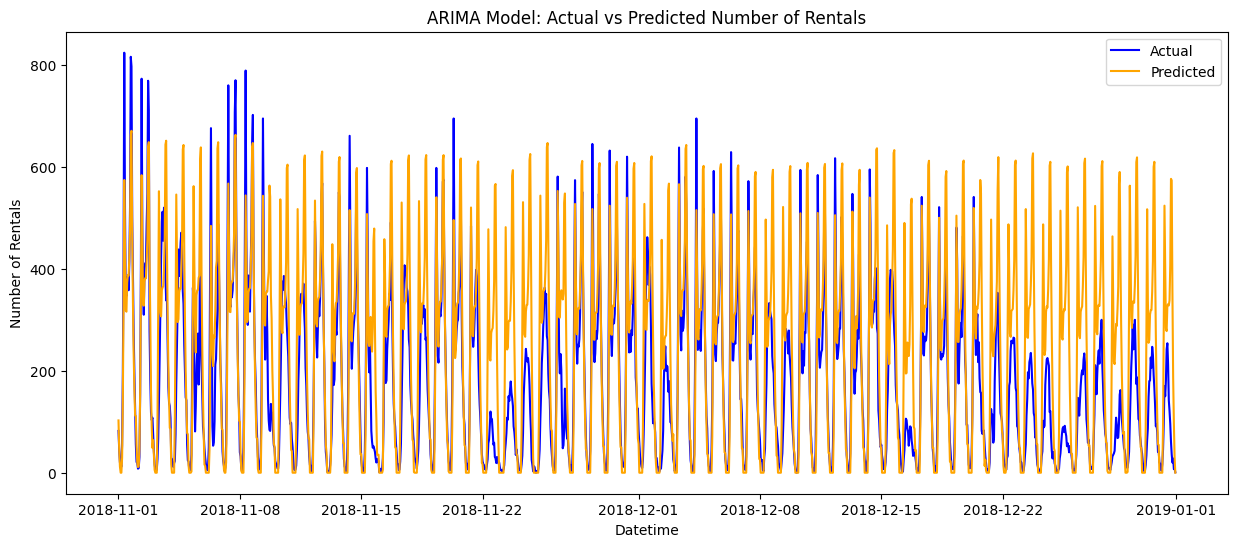

In [39]:
new_col = f'pred_{PICKUP_TARGET_COL}'
mae, rmse = sarimax_fit_predict(train_data, test_data, PICKUP_TARGET_COL, order, s_order, new_col, train_exog_short, test_exog_short)


## Comparison of performance of best time series model and NN on dropoffs

### NEURAL NETWORK

In [40]:
scaler_dropoff = StandardScaler()
X_dropoff_final_scaled = scaler_dropoff.fit_transform(X_d_train_final)
X_dropoff_test_scaled = scaler_dropoff.transform(X_d_test)

In [ ]:
d_final_model = create_nn_and_train(X_dropoff_final_scaled, y_d_train_final)
y_val_flat_d_final, y_pred_flat_d_final, mae_d_final, rmse_d_final = predict_nn(d_final_model, X_dropoff_test_scaled, y_d_test)

Epoch 1/50


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 86292.6172 - val_loss: 133846.9375
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 85946.2969 - val_loss: 133216.9688
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 85353.0312 - val_loss: 132009.0938
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 84274.7656 - val_loss: 129580.5859
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 82249.4844 - val_loss: 125191.5078
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 78639.9844 - val_loss: 117365.5547
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 72900.0391 - val_loss: 105083.4922
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 64518.7383 - val_loss: 87800.7812
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54500.7266 - val_loss: 66579.3047
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44637.9375 - val_loss: 46190.7930
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34426.9102 - val_loss: 32473.7852
Epoch 12/50

## SARIMAX

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 7296
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -40719.672
Date:                              Sat, 29 Nov 2025   AIC                          81461.344
Time:                                      18:52:39   BIC                          81537.146
Sample:                                  01-01-2018   HQIC                         81487.415
                                       - 10-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feelslike      4.4587      0.440     10.142      0.000       3.597       5.320
precip        -6.41

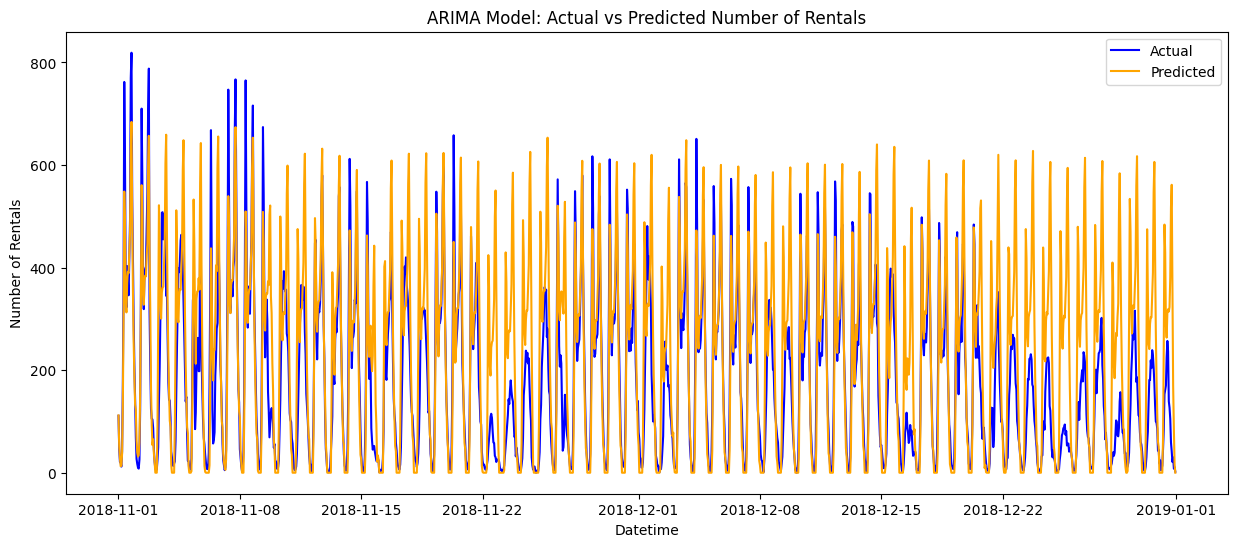

In [43]:
new_col = f'pred_{DROPOFF_TARGET_COL}'
mae, rmse = sarimax_fit_predict(train_data, test_data, DROPOFF_TARGET_COL, order, s_order, new_col, train_exog_short, test_exog_short)


In [44]:
performance_dropoffs

{'model_sarima': {'val_mae': 75.03, 'val_rmse': 118.11},
 'model_sarimax': {'val_mae': 94.58, 'val_rmse': 128.24},
 'model_sarimax_short': {'val_mae': 81.95, 'val_rmse': 118.2},
 'model_sarimax_short_w_date': {'val_mae': 100.52, 'val_rmse': 130.48},
 'model_nn': {'val_mae': 75.69, 'val_rmse': 122.71}}

In [45]:
performance_pickup

{'model_sarima': {'val_mae': 77.63, 'val_rmse': 123.46},
 'model_sarimax': {'val_mae': 95.24, 'val_rmse': 130.3},
 'model_sarimax_short': {'val_mae': 83.04, 'val_rmse': 120.34},
 'model_sarimax_short_w_date': {'val_mae': 94.82, 'val_rmse': 128.17},
 'model_nn': {'val_mae': 93.2, 'val_rmse': 145.09}}

# Task 3

In [ ]:
required_bikes_per_cluster={}

for cluster_id in avg_bikes_per_cluster["station_cluster"]:
    cluster = data[data['station_cluster'] == cluster_id]
    print(f'cluster_id: {cluster_id}')
    hourly_pickups_cluster = cluster.groupby(['pickup_datetime'])['bikeid'].size().reset_index(name='num_rentals')
    hourly_dropoffs_cluster = cluster.groupby(['dropoff_datetime'])['bikeid'].size().reset_index(name='num_rentals')
    hourly_cluster = pd.merge(hourly_pickups_cluster, hourly_dropoffs_cluster, left_on='pickup_datetime', right_on='dropoff_datetime', how='outer', suffixes=('_pickups', '_dropoffs')).drop(columns=['dropoff_datetime']).rename(columns={'pickup_datetime': 'datetime'})
    hourly_cluster['datetime'] = pd.to_datetime(hourly_cluster['datetime'])
    hourly_cluster = hourly_cluster[hourly_cluster['datetime'] < '2019-01-01']

    print(f'size of hourly_cluster: {hourly_cluster.shape}')
    hourly_cluster = fill_missing_hours(hourly_cluster)
    print(f'size of hourly_cluster after filling missing hours: {hourly_cluster.shape}')

    train_data = hourly_cluster.set_index('datetime')
    train_data.index = pd.to_datetime(train_data.index)

    exog  = weather_cleaned.set_index('datetime')
    df_pickup = get_dataset(hourly_cluster, n_lags, forecast_horizon, PICKUP_TARGET_COL)
    df_dropoff =get_dataset(hourly_cluster, n_lags, forecast_horizon, DROPOFF_TARGET_COL)

    last_pickup =  df_pickup.iloc[-1].copy()
    df_pickup_train = df_pickup.iloc[:-1].copy()
    last_dropoff =  df_dropoff.iloc[-1].copy()
    df_dropoff_train = df_dropoff.iloc[:-1].copy()


    X_pickup = df_pickup_train[[f'target_lag_{lag}' for lag in range(1, n_lags+1)] + exog_features].values
    y_pickup = df_pickup_train[[f'target_+{step}' for step in range(1, forecast_horizon+1)]].values
    last_pickup_to_predict = last_pickup[[f'target_lag_{lag}' for lag in range(1, n_lags+1)] + exog_features].values.reshape(1, -1)
  
    X_dropoff = df_dropoff_train[[f'target_lag_{lag}' for lag in range(1, n_lags+1)] + exog_features].values
    y_dropoff = df_dropoff_train[[f'target_+{step}' for step in range(1, forecast_horizon+1)]].values
    last_dropoff_to_predict = last_dropoff[[f'target_lag_{lag}' for lag in range(1, n_lags+1)] + exog_features].values.reshape(1, -1)

    scaler_pickup = StandardScaler()
    X_pickup_train_scaled = scaler_pickup.fit_transform(X_pickup)
    last_pickup_to_predict_scaled = scaler_pickup.transform(last_pickup_to_predict)

    scaler_dropoff = StandardScaler()
    X_dropoff_train_scaled = scaler_dropoff.fit_transform(X_dropoff)
    last_dropoff_to_predict_scaled = scaler_dropoff.transform(last_dropoff_to_predict)
    
    p_final_model = create_nn_and_train(X_pickup_train_scaled, y_pickup)
    d_final_model = create_nn_and_train(X_dropoff_train_scaled, y_dropoff)

    p_pred = np.round(np.clip(p_final_model.predict(last_pickup_to_predict_scaled), 0, None))
    d_pred = np.round(np.clip(d_final_model.predict(last_dropoff_to_predict_scaled), 0 ,None))

    cum_net = np.cumsum(d_pred - p_pred)
    required_bikes = max(0, -cum_net.min())
    required_bikes_per_cluster[cluster_id] = required_bikes

cluster_id: 11
size of hourly_cluster: (8721, 3)
size of hourly_cluster after filling missing hours: (8760, 3)
Epoch 1/50


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 95827.0312 - val_loss: 69034.4688
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 95162.5781 - val_loss: 68503.2812
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 93811.1250 - val_loss: 67444.1953
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 90931.5391 - val_loss: 65414.9297
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 85366.4844 - val_loss: 61836.1602
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 76179.1328 - val_loss: 56179.3320
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 62638.1055 - val_loss: 48655.7891
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47865.6797 - val_loss: 40747.3516
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35685.2695 - val_loss: 34362.4023
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30197.7539 - val_loss: 30972.7285
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27008.3125 - val_loss: 30114.9902
Epoch 12/50
9/9 ━━

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 93472.5469 - val_loss: 66282.2422
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 92825.5000 - val_loss: 65848.6562
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 91643.7734 - val_loss: 65044.2852
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 89189.8203 - val_loss: 63507.6328
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 84646.7344 - val_loss: 60781.7969
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 77168.0859 - val_loss: 56393.6094
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 65917.5391 - val_loss: 50192.0078
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52103.6641 - val_loss: 42822.3086
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38666.6445 - val_loss: 35934.1328
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30640.0742 - val_loss: 31137.7422
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27149.9688 - val_loss: 29099.9297
Epoch 12/50
9/9 ━━

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 54399.3125 - val_loss: 34217.8320
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53898.3750 - val_loss: 33965.5820
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52903.5938 - val_loss: 33453.0352
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50922.4648 - val_loss: 32449.0586
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47092.2578 - val_loss: 30651.7676
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 40828.2383 - val_loss: 27775.8750
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32518.0840 - val_loss: 23903.1582
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23908.5762 - val_loss: 19741.5078
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18851.0352 - val_loss: 16689.2129
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16404.2383 - val_loss: 15217.5732
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14794.6602 - val_loss: 14782.4062
Epoch 12/50
9/9 ━━

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 46205.7656 - val_loss: 32425.5234
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 45561.8945 - val_loss: 32026.7773
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44261.4570 - val_loss: 31264.1289
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 41642.3672 - val_loss: 29874.8398
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37048.2305 - val_loss: 27577.4785
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30615.7148 - val_loss: 24384.3105
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23010.6738 - val_loss: 20765.5547
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17040.7754 - val_loss: 17748.4258
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 13951.0244 - val_loss: 16329.7305
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12540.3838 - val_loss: 15933.8574
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11094.1680 - val_loss: 15663.2549
Epoch 12/50
9/9 ━

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 54743.3086 - val_loss: 44592.7891
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54207.5586 - val_loss: 44110.1719
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 53147.6445 - val_loss: 43250.7969
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51256.4727 - val_loss: 41766.7305
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47766.3320 - val_loss: 39352.8164
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42462.0898 - val_loss: 35661.1094
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35104.8047 - val_loss: 30689.1875
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26826.5371 - val_loss: 25096.3887
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19518.7578 - val_loss: 19942.8047
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15103.3525 - val_loss: 16478.2988
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12885.4453 - val_loss: 14626.9512
Epoch 12/50
9/9 ━━

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 49978.5117 - val_loss: 28118.5547
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49430.3438 - val_loss: 27869.4473
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48248.6016 - val_loss: 27372.1641
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45774.5859 - val_loss: 26395.1523
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41064.9297 - val_loss: 24672.8438
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33844.0430 - val_loss: 21992.1445
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25166.5918 - val_loss: 18635.6855
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17827.4297 - val_loss: 15594.4512
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14595.8906 - val_loss: 14050.9688
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13163.0049 - val_loss: 13776.9580
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12117.8047 - val_loss: 14004.5020
Epoch 12/50
9/9 ━━

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 30754.4434 - val_loss: 22393.3711
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30338.2578 - val_loss: 22116.9746
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29458.9121 - val_loss: 21564.5078
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27614.7812 - val_loss: 20524.2207
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24381.4551 - val_loss: 18750.0801
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19567.4160 - val_loss: 16173.4883
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13897.1016 - val_loss: 13259.9961
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10603.6387 - val_loss: 11009.0596
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9218.3086 - val_loss: 10053.7539
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8361.1953 - val_loss: 9810.4658
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7988.4614 - val_loss: 9893.1729
Epoch 12/50
9/9 ━━━━━━━

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 27180.3320 - val_loss: 18072.9043
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26932.7559 - val_loss: 17870.6973
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26425.1875 - val_loss: 17484.1797
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25293.9980 - val_loss: 16735.7168
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23187.1953 - val_loss: 15408.3750
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19383.2773 - val_loss: 13424.6953
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14474.8232 - val_loss: 11132.9111
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10559.0059 - val_loss: 9333.3252
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8087.4209 - val_loss: 8460.0732
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7418.5732 - val_loss: 8099.9038
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6970.1343 - val_loss: 8179.5137
Epoch 12/50
9/9 ━━━━━━━━━

In [ ]:
required_bikes_per_cluster

{11: 0,
 22: 434.0,
 26: 14.0,
 1: 73.0,
 8: 364.0,
 5: 139.0,
 16: 4.0,
 4: 10.0,
 13: 8.0,
 17: 294.0,
 27: 120.0,
 3: 6.0,
 12: 0,
 24: 0,
 21: 0,
 18: 37.0,
 6: 0,
 25: 35.0,
 23: 77.0,
 7: 18.0,
 20: 8.0,
 15: 27.0,
 2: 2.0,
 14: 6.0,
 9: 43.0}